*italicized text*### Weighted Model
In this notebook, we examine using weights to calculate loss during BERT training: https://www.sciencedirect.com/science/article/pii/S1389128621002711#sec3.3


In [1]:
!pip install pyyaml h5py
!pip install -q transformers
!pip install pydot --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from transformers import BertTokenizer, TFBertModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
NOTEBOOK_LOC = "/content/drive/MyDrive/Colab Notebooks/W266 Final Project/"

### Load Data

Also format data for weighted BERT below

In [5]:
TRAIN_TEXTS = []
VALID_TEXTS = []

TRAIN_LABELS = []
VALID_LABELS = []

TRAIN_WEIGHTS = []

TARGET_NAMES = ["disagree", "neutral", "agree"]

CV_IDX = [0, 1, 2, 3, 4]

for cv_idx in CV_IDX:

  training_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_training_"+str(cv_idx)+".tsv")
  valid_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_val_"+str(cv_idx)+".tsv")


  train_texts = training_data["sentence"].to_list()
  train_labels = np.asarray(training_data["stance_id"].astype(int).to_list())

  valid_texts = valid_data["sentence"].to_list()
  valid_labels = np.asarray(valid_data["stance_id"].astype(int).to_list())

  training_data["weight"] = training_data[["agree", "neutral", "disagree"]].max(axis=1)
  train_weights = np.asarray(training_data["weight"]) # add label weights

  TRAIN_TEXTS.append(train_texts)
  VALID_TEXTS.append(valid_texts)

  TRAIN_LABELS.append(train_labels)
  VALID_LABELS.append(valid_labels)

  TRAIN_WEIGHTS.append(train_weights)

test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_texts = test_data["sentence"].to_list()
test_labels = np.asarray(test_data["stance_id"].astype(int).to_list())

### BERT Setup

In [6]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

max_length = 256

TRAIN_ENCODINGS = []
VALID_ENCODINGS = []
TEST_ENCODINGS = []

for cv_idx in CV_IDX:

  train_encodings = bert_tokenizer(train_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  test_encodings = bert_tokenizer(test_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

  TRAIN_ENCODINGS.append(train_encodings)
  VALID_ENCODINGS.append(valid_encodings)
  TEST_ENCODINGS.append(test_encodings)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Weighted BERT
The DeSmog paper suggests that using the model weights yielded the best-performing model. We attempt to re-create that here. (Note: the code for this was not included in the paper in any usable format, so this implementation is original work.)

Electing to use base-line BERT initializations

https://www.sciencedirect.com/science/article/pii/S1389128621002711

Use Keras fit sample_weight to adjust loss function by probability. 

In [7]:
def create_weighted_bert_multiclass_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(len(TARGET_NAMES), activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    return classification_model

----------------------Training Cross Fold: 4----------------------
Epoch 1/7
93/93 [==============================] - 77s 662ms/step - loss: 0.2314 - accuracy: 0.9024 - val_loss: 1.2443 - val_accuracy: 0.6423
Epoch 2/7
93/93 [==============================] - 58s 625ms/step - loss: 0.1364 - accuracy: 0.9492 - val_loss: 1.1807 - val_accuracy: 0.6504
Epoch 3/7
93/93 [==============================] - 53s 565ms/step - loss: 0.0914 - accuracy: 0.9722 - val_loss: 1.2606 - val_accuracy: 0.6287
Epoch 4/7
93/93 [==============================] - 53s 566ms/step - loss: 0.0565 - accuracy: 0.9804 - val_loss: 1.4994 - val_accuracy: 0.6423
Epoch 5/7
93/93 [==============================] - 53s 566ms/step - loss: 0.0584 - accuracy: 0.9817 - val_loss: 1.6259 - val_accuracy: 0.6423
Epoch 6/7
93/93 [==============================] - 53s 566ms/step - loss: 0.0543 - accuracy: 0.9858 - val_loss: 1.4229 - val_accuracy: 0.6450
Epoch 7/7
93/93 [==============================] - 58s 626ms/step - loss: 0.0290 

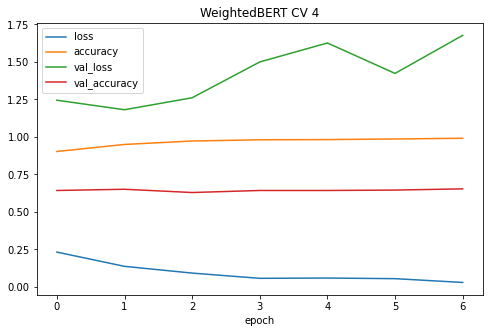

              precision    recall  f1-score   support

    disagree       0.73      0.56      0.64        39
     neutral       0.67      0.71      0.69        85
       agree       0.69      0.72      0.71        76

    accuracy                           0.69       200
   macro avg       0.70      0.66      0.68       200
weighted avg       0.69      0.69      0.68       200



In [11]:
MODEL_NAME = "WeightedBERT"
EPOCHS = 7

for cv_idx in CV_IDX[4:]:

  model = create_weighted_bert_multiclass_model(hidden_size=100)

  print("----------------------Training Cross Fold: " + str(cv_idx) + "----------------------")

  checkpoint_filepath = 'Models/' + MODEL_NAME + str(cv_idx)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_freq='epoch',
      save_best_only=True)

  model_history = model.fit([TRAIN_ENCODINGS[cv_idx].input_ids, TRAIN_ENCODINGS[cv_idx].token_type_ids, TRAIN_ENCODINGS[cv_idx].attention_mask], 
                                                  TRAIN_LABELS[cv_idx],   
                                                  validation_data=([VALID_ENCODINGS[cv_idx].input_ids, VALID_ENCODINGS[cv_idx].token_type_ids, VALID_ENCODINGS[cv_idx].attention_mask], 
                                                  VALID_LABELS[cv_idx]),    
                                                  batch_size=16,  
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=EPOCHS,
                                                  sample_weight = TRAIN_WEIGHTS[cv_idx])
  
  pd.DataFrame(model_history.history).plot(figsize=(8,5))
  plt.title(MODEL_NAME+' CV ' + str(cv_idx))
  plt.xlabel('epoch')
  plt.savefig(NOTEBOOK_LOC + '/ModelResults/' + MODEL_NAME + str(cv_idx) + ".png")
  plt.show()
  
  model.load_weights(checkpoint_filepath)
  test_predictions = model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask]) 
  print(classification_report(test_labels, np.argmax(test_predictions, axis=1), target_names=TARGET_NAMES))

  np.save(NOTEBOOK_LOC + '/ModelResults/TestPredictions' + MODEL_NAME + str(cv_idx), test_predictions, allow_pickle=True)